In [1]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')

2024-12-09 17:39:49.068914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2024-12-09 17:39:49.069235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2024-12-09 17:39:49.069655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2024-12-09 17:39:49.070092: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cufft64_10.dll'; dlerror: cufft64_10.dll not found
2024-12-09 17:39:49.070430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'curand64_10.dll'; dlerror: curand64_10.dll not found
2024-12-09 17:39:49.070762: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

[]
Num GPUs Available:  0


In [3]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [4]:
df1.iloc[:, 3:]

,G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


In [5]:
c=-1
P_exp=np.array(df1.iloc[:, 3:].drop('H1',axis=1))[:c]
T_exp=np.array(df1['Time [s]'])[:c]

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
N_exp,T_max

(14, 337235.3)

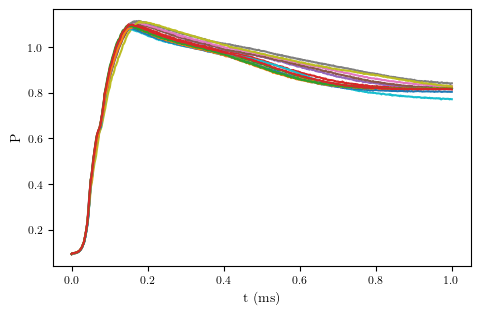

In [6]:
for i in range(N_exp):
    plt.plot(T_exp,P_exp[:, i])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

In [7]:
N_f = 500 # Number of residual point
N_d = 500 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = T_star.min(0)
ub = T_star.max(0) 

# Initial Condition
xx0 = T_star[::len(T_exp)]
uu0 = P_star[::len(T_exp)]

xx1= np.ones((len(xx0),1))

xx01=np.vstack((xx0, xx1))
uu01=np.array([1]*N_exp+[0]*N_exp).reshape([-1,1])

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu0), replace=False)
xxd = T_star[idx]
uud = P_star[idx]

T_u_train = np.concatenate((xx0,xxd)).reshape([-1,1])
p_train = np.concatenate((uu0,uud)).reshape([-1,1])

T_f_train = lb + (ub-lb)*lhs(1, N_f)

T_u_train_tf = tf.convert_to_tensor(T_u_train, dtype=tf.float32)
p_train_tf =   tf.convert_to_tensor(p_train, dtype=tf.float32)
T_f_train_tf = tf.convert_to_tensor(T_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)
xx01_tf = tf.convert_to_tensor(xx01, dtype=tf.float32)
uu01_tf = tf.convert_to_tensor(uu01, dtype=tf.float32)

2024-12-09 17:39:50.197086: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


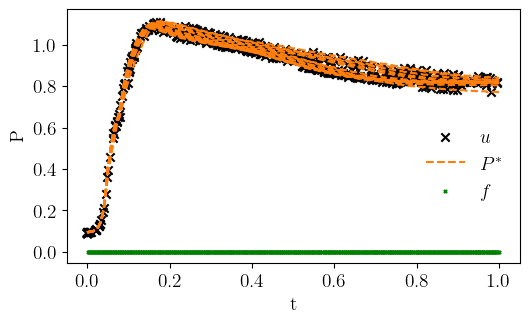

In [8]:
colors = plt.cm.tab10.colors
plt.scatter(T_u_train, p_train, marker='x', color='black',label='$u$')

plt.plot(T_star[:len(T_exp)],P_star_tf[:len(T_exp)], color = colors[1], linestyle='--', label='$P^*$')

for i in range(1, N_exp):
    plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star_tf[i*len(T_exp):(i+1)*len(T_exp)], color = colors[1], linestyle='--')
plt.scatter(T_f_train_tf, np.zeros_like(T_f_train_tf), marker='x', s=5, color='green',label='$f$')

plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.6))
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
# plt.savefig('../Img/412/u.png')
# plt.savefig('../Img/412/u.pdf')
# plt.savefig('../Img/412/u.svg')
# plt.savefig('figures/P_phi.pdf')
plt.show()


In [9]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 2]), dtype=tf.float32)
    alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, N_exp*2), (N_exp*2, -1))) 
    return alpha_r, alpha_b, alpha_0

#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, W_p, b_p, W_phi, b_phi, lnv):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        u=net(t, W_p, b_p)

        lnp=u[:,0:1]
        lns=u[:,1:2]
        p=tf.exp(lnp)
        s=tf.exp(lns)
        m=tf.exp(lnv[0:1])
        
        phi=net(tf.concat([p, s],1), W_phi, b_phi)

    p_t = tape1.gradient(p, t) 
    s_t = tape1.gradient(s, t) 
    f_p = p_t - phi*p
    f_s = s_t + m[0]*p*s
    
    return f_p, f_s


#@tf.function()
# @tf.function()
def train_step(W_p, b_p, W_phi, b_phi, X_u_train_tf, p_train_tf, X_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv, opt):
    
    t_u = X_u_train_tf
    t_f = X_f_train_tf

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi, lambda_r, lambda_b, lambda_0, lnv])
        u_nn = net(t_u, W_p, b_p) 
        lnp=u_nn[:,0:1]
        lns=u_nn[:,1:2]
        p_nn=tf.exp(lnp)
        f_p, f_s = net_f(t_f, W_p, b_p, W_phi, b_phi, lnv)

        u_00 = net(xx01_tf, W_p, b_p) 
        lns_0=u_00[:,1:2]
        s_00=tf.exp(lns_0)


        loss_p = tf.square(lambda_b*(p_nn - p_train_tf))
        loss_0s = tf.square(lambda_0*(s_00 - uu01_tf))
        loss_fp = tf.square(lambda_r*f_p) 
        loss_fs = tf.square(lambda_r*f_s) 
        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_fs)+ tf.reduce_mean(loss_0s)

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))
    grads_lnv = tape.gradient(loss, lnv)
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    grads_0 = tape.gradient(loss, lambda_0)

    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
    opt.apply_gradients(zip([grads_lnv], [lnv]))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    opt.apply_gradients(zip([-grads_0], [lambda_0]))
   
    return loss, tf.reduce_mean(loss_p), tf.reduce_mean(loss_fp), tf.reduce_mean(loss_fs)



layers = [1, 50, 50, 2]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [2, 50, 50, 1]


W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lambda_r, lambda_b, lambda_0 = loss_weight(N_f, N_d)
lnv = tf.Variable(tf.reshape(tf.repeat(1.0, 1), (1, -1)), dtype=tf.float32) 

In [10]:
lr = 5e-3




optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer2 = tf.optimizers.Adam(learning_rate=lr/10)
# optimizer3 = tf.optimizers.Adam(learning_rate=lr/100)
# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer3 = tf.optimizers.Adam(learning_rate=lr/40)

# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9, clipnorm=10.0)


start_time = time.time()
it=0
loss = []
loss_d = []
loss_fisp = []
loss_fiss = []
loss_reg=[]
# loss_fisa = []

# Make a new Function and ConcreteFunction for each optimizer.
train_step_1 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, T_u_train_tf, p_train_tf, T_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv, optimizer)
train_step_2 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, T_u_train_tf, p_train_tf, T_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv, optimizer2)
train_step_3 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, T_u_train_tf, p_train_tf, T_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv, optimizer2)


In [11]:
Nmax=10**5


while it <= Nmax:
    if it<10**5:
        loss_, loss_p, loss_fp, loss_fs = train_step_1(W_p, b_p, W_phi, b_phi, T_u_train_tf, p_train_tf, T_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv)
    elif it< 2*10**5:
        loss_, loss_p, loss_fp, loss_fs = train_step_2(W_p, b_p, W_phi, b_phi, T_u_train_tf, p_train_tf, T_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv)
    else:
        loss_, loss_p, loss_fp, loss_fs = train_step_3(W_p, b_p, W_phi, b_phi, T_u_train_tf, p_train_tf, T_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv)

    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fisp.append(loss_fp)
    loss_fiss.append(loss_fs)
    # loss_fisa.append(loss_fa)



    if it % 10 == 0:

        print(f"Iteration is: {it}")
        print(f"Total loss is: {loss_}")
        print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p is: {loss_fp}")
        print(f"Physicial loss of s is: {loss_fs}")
        # if n%10000 ==0:
        #     loss_reg_=eval(W_p, b_p, W_phi_s, b_phi_s)
        #     loss_reg.append(loss_reg_)
        # print(f"Physicial loss of a is: {loss_fa}")

    it+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 551003.75
Data loss is: 176574.65625
Physicial loss of p is: 1.7663004398345947
Physicial loss of s is: 7.212355613708496
Iteration is: 10
Total loss is: 74546.2734375
Data loss is: 60257.8984375
Physicial loss of p is: 0.08594514429569244
Physicial loss of s is: 0.0031439820304512978
Iteration is: 20
Total loss is: 53720.24609375
Data loss is: 52792.21484375
Physicial loss of p is: 0.22506564855575562
Physicial loss of s is: 0.7485673427581787
Iteration is: 30
Total loss is: 54063.1171875
Data loss is: 54043.77734375
Physicial loss of p is: 0.09655417501926422
Physicial loss of s is: 1.7301552295684814
Iteration is: 40
Total loss is: 51442.44921875
Data loss is: 51279.17578125
Physicial loss of p is: 0.01354038342833519
Physicial loss of s is: 2.5011959075927734
Iteration is: 50
Total loss is: 48868.0078125
Data loss is: 48819.15625
Physicial loss of p is: 0.027308793738484383
Physicial loss of s is: 3.058321237564087
Iteration is: 60
Total loss is: 4566

In [12]:
Nmax=len(loss)

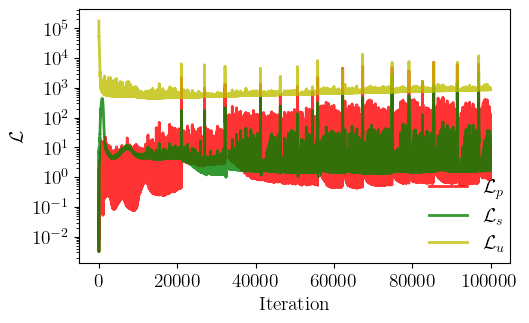

In [13]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]

loss_phip_list = [loss_fisp[i].numpy() for i in range(0,Nmax)]
loss_phis_list = [loss_fiss[i].numpy() for i in range(0,Nmax)]



plt.semilogy(it, np.asarray(loss_phip_list), 'r-', linewidth = 2, alpha=0.8,  label = '$\mathcal{L}_p$')    
plt.semilogy(it, np.asarray(loss_phis_list), 'g-', linewidth = 2, alpha=0.8,  label = '$\mathcal{L}_s$')   
plt.semilogy(it, np.asarray(loss_data_list), 'y-', linewidth = 2, alpha=0.8, label = '$\mathcal{L}_u$')  


plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(0.77, 0.4))
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\mathcal{L}$', fontsize=14)    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/412/Loss_split.png')
plt.savefig('../Img/412/Loss_split.pdf')
plt.savefig('../Img/412/Loss_split.svg')
plt.show()

In [14]:
lnv[0], tf.exp(lnv[0]), #lnv[1], tf.exp(lnv[1])


(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.2961156], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([9.935514], dtype=float32)>)

In [15]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
T_star_tf = tf.convert_to_tensor(T_star[:len(T_exp)], dtype=tf.float32)    
u_pred = predict(T_star_tf, W_p, b_p)

# ## Evaluating unknown function
lnp=u_pred[:,0:1]
lns=u_pred[:,1:2]
p=tf.exp(lnp)
s=tf.exp(lns)
phi_pred = predict(tf.concat([p, s],1), W_phi, b_phi)
phi_s=np.array(p*s*tf.exp(lnv[0]))


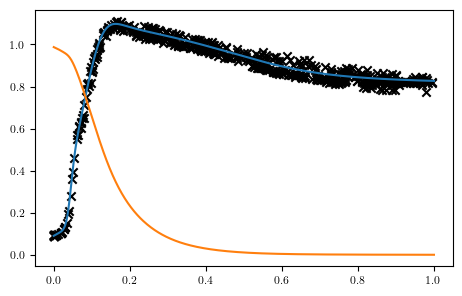

In [16]:
plt.plot(T_star_tf, p, label='Prediction P')
plt.plot(T_star_tf, s, label='Prediction S')

# for i in range(N_exp):
#     plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')



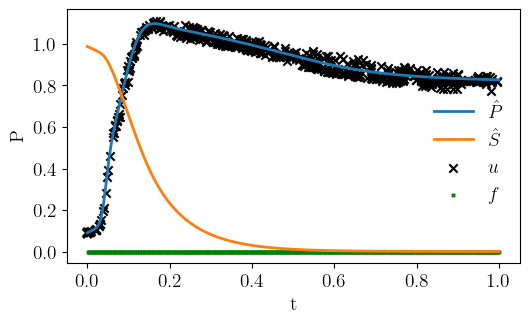

In [17]:
# plt.plot(T_star_tf, p, label='Prediction P')
# plt.plot(T_star_tf, s, label='Prediction S')

# # for i in range(N_exp):
# #     plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

# plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')


plt.plot(T_star_tf, p, linestyle='-',linewidth=2, label='$\hat{P}$')
plt.plot(T_star_tf, s, linestyle='-',linewidth=2, label='$\hat{S}$')
plt.scatter(T_u_train, p_train, marker='x', color='black',label='$u$')
plt.scatter(T_f_train_tf, np.zeros_like(T_f_train_tf), marker='x', s=5, color='green',label='$f$')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/412/Result.png')
plt.savefig('../Img/412/Result.pdf')
plt.savefig('../Img/412/Result.svg')
plt.show()

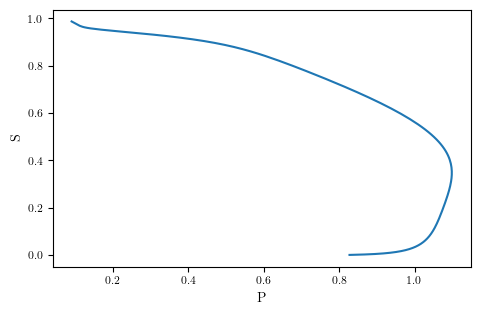

In [18]:
plt.plot(p, s)
plt.xlabel('P')
plt.ylabel('S')
# plt.savefig('figures/P_phi.pdf')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


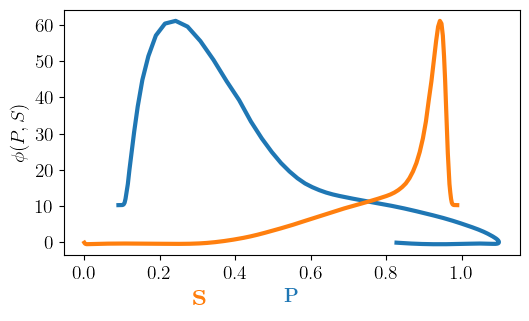

In [19]:
plt.plot(p, phi_pred,linewidth=3)
plt.plot(s, phi_pred, linewidth=3)
# plt.scatter(X_f_train_tf, np.zeros_like(X_f_train), marker='x', s=5, color='green',label='$f$')

# plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel(r'$\mathbf{P}$', fontsize=14, color=colors[0])
plt.text(0.3, -0.2, r'$\mathbf{s}$', fontsize=24, color=colors[1], ha='center', transform=plt.gca().transAxes)

plt.ylabel('$\phi(P, S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/412/Result_phi.png')
plt.savefig('../Img/412/Result_phi.pdf')
plt.savefig('../Img/412/Result_phi.svg')
plt.show()

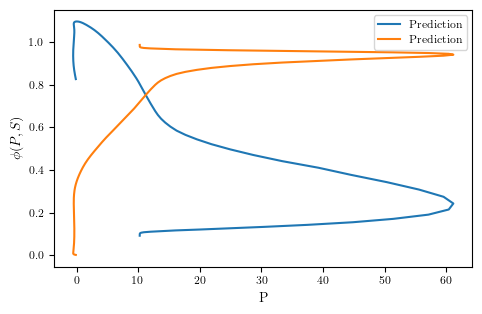

In [20]:
plt.plot(phi_pred, p, label='Prediction')
plt.plot(phi_pred,s, label='Prediction')

# plt.plot(u_pred[:,1:2], phi_pred, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('P')
plt.ylabel('$\phi(P,S)$')
# plt.savefig('figures/phi.pdf')
plt.show()

In [21]:
Nt=10000
T_int=np.zeros(Nt)
P_int=np.zeros(Nt)
S_int=np.zeros(Nt)

dt=0.0001

T_int[0]=0
# P_int[0]=np.mean(uu1) #Initial conditions
P_int[0]=np.array(p[0]) #Initial conditions
S_int[0]=np.array(s[0]) #Initial conditions


for i in range(1,Nt):

    PS_p=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    P_int[i]=P_int[i-1]+predict(PS_p , W_phi, b_phi)*P_int[i-1]*dt
    # P_int[i]=max(P_int[i],0)
    S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]* tf.exp(lnv[0])*dt
    # P_int[i]=max(S_int[i],0)
    T_int[i]=T_int[i-1]+dt

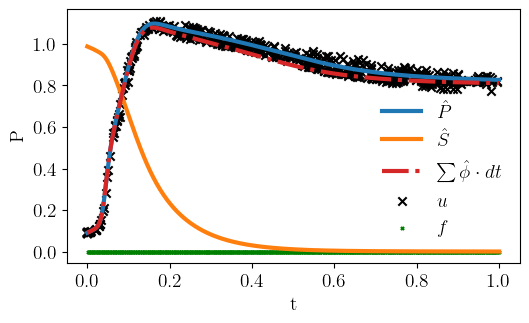

In [22]:
# plt.plot(T_star_tf, p, label='Prediction P')
# plt.plot(T_star_tf, s, label='Prediction S')

# # for i in range(N_exp):
# #     plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

# plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')


plt.plot(T_star_tf, p, linestyle='-',linewidth=3, label='$\hat{P}$')
plt.plot(T_star_tf, s, linestyle='-',linewidth=3, label='$\hat{S}$')
plt.plot(T_int, P_int, linestyle='-.',linewidth=3, color=colors[3], label='$\sum \hat{\phi} \cdot dt$')

plt.scatter(T_u_train, p_train, marker='x', color='black',label='$u$')
plt.scatter(T_f_train_tf, np.zeros_like(T_f_train_tf), marker='x', s=5, color='green',label='$f$')

# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/412/Result_int.png')
plt.savefig('../Img/412/Result_int.pdf')
plt.savefig('../Img/412/Result_int.svg')
plt.show()

# Symbolic Regresion

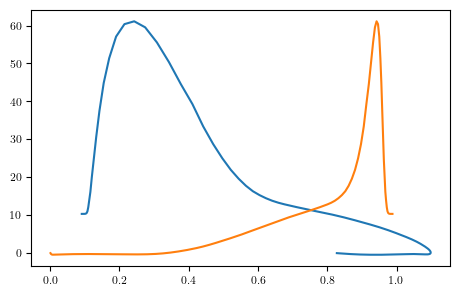

In [23]:
c=0
d=-1
plt.plot(p[c:d], np.array(phi_pred)[c:d])
plt.plot(s[c:d], np.array(phi_pred)[c:d])


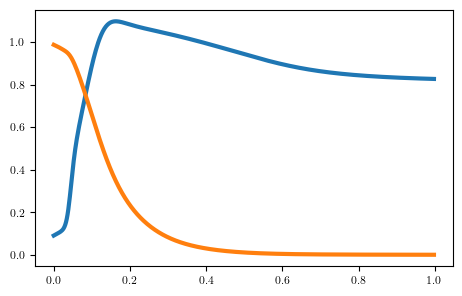

In [24]:
plt.plot(T_star_tf[c:d], p[c:d], linestyle='-',linewidth=3, label='$\hat{P}$')
plt.plot(T_star_tf[c:d], s[c:d], linestyle='-',linewidth=3, label='$\hat{S}$')

In [25]:
max_cols_phi=tf.reshape(tf.math.reduce_max(phi_pred[c:d], axis=0), [-1, 1])
min_cols_phi = tf.reshape(tf.math.reduce_min(phi_pred[c:d], axis=0), [-1, 1])
phi_scaled = (phi_pred[c:d]-min_cols_phi)/(max_cols_phi-min_cols_phi)


In [26]:
# Create and train the PySR model
model_phi= PySRRegressor(
    niterations=700,
    binary_operators=["+", "*", "inv(x, y) = x/(x + y)"],
    # unary_operators=["inv(x) = 1/x"],
    # unary_operators=["exp","inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x, y: x/(x+y),},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    complexity_of_variables=1,
    complexity_of_constants=1,
    complexity_of_operators={"inv": 3},
    parsimony=0.000001,
    # select_k_features=1,
    # constraints={"constant": 0},
    maxsize=30,
    progress=True  # Show progress during training
)

In [27]:
# Fit phi
model_phi.fit(tf.concat([p[c:d], s[c:d]],1), phi_scaled)
# model_phi.fit(s[c:d], phi_scaled)

print(model_phi)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 2.500e+05
Head worker occupation: 31.8%
Progress: 574 / 10500 total iterations (5.467%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           8.030e-01  1.594e+01  y = x₀
3           8.479e-03  2.275e+00  y = x₁ * 0.3637
5           6.529e-03  1.306e-01  y = 0.46878 * (x₁ * x₁)
7           6.294e-03  1.831e-02  y = 0.68388 * ((-0.27137 + x₁) * x₁)
11          5.248e-03  4.544e-02  y = ((x₁ * inv(x₀, 0.16351)) * x₁) * x₁
13          3.270e-03  2.365e-01  y = x₁ * inv((-1.077 + x₁) + x₀, x₀ * x₀)
15          2.419e-03  1.507e-01  y = x₁ * inv(((-1.077 + x₁) + x₀) * x₁, x₀ * x₀)
17          2.000e-03  9.509e-02  y = ((x₁ * inv(x₀ + (-1.077 + x₁), x₀ * x₀)) * 1.2398) * x₁
19          1.406e-03  1.764e-01  y = ((1.4739 * x₁) * x₁) * inv(inv(x₀ + (x₁ + -1.0783), x₀), x...
                                  ₀)
21          9.561e-04  1.927e-01  y =

In [28]:
import sympy


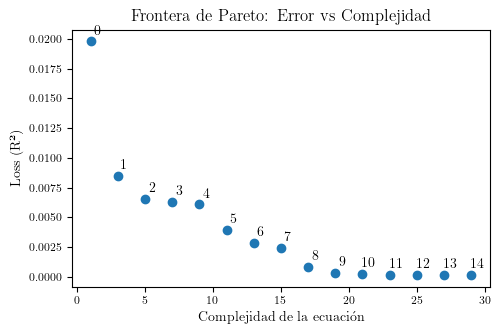

In [29]:
# Extraer las métricas de las ecuaciones
equations_df = model_phi.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()

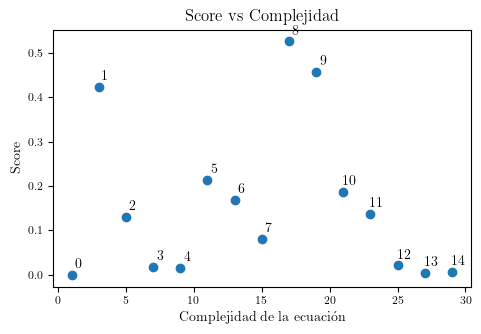

In [30]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [31]:
equations_df


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.019790,0.000000,0.044277463,0.0442774630000000,PySRFunction(X=>0.0442774630000000)
1,3,0.008479,0.423794,x1 * 0.3636841,x1*0.3636841,PySRFunction(X=>x1*0.3636841)
2,5,0.006529,0.130637,0.46877843 * (x1 * x1),0.46877843*x1*x1,PySRFunction(X=>0.46877843*x1*x1)
3,7,0.006294,0.018317,0.68596417 * (x1 * (x1 + -0.27232093)),0.68596417*x1*(x1 - 0.27232093),PySRFunction(X=>0.68596417*x1*(x1 - 0.27232093))
4,9,0.006090,0.016543,x1 * (((x0 * -0.3716683) * x0) + 0.5058921),x1*(x0*(-0.3716683)*x0 + 0.5058921),PySRFunction(X=>x1*(x0*(-0.3716683)*x0 + 0.505...
5,11,0.003970,0.213949,"((x1 * x1) + inv(-0.04249576, x0)) * x1",x1*(x1*x1 - 0.04249576/(x0 - 0.04249576)),PySRFunction(X=>x1*(x1*x1 - 0.04249576/(x0 - 0...
6,13,0.002836,0.168170,"((inv(-0.04170901, x0) + (x1 * x1)) * x1) * x1",x1*x1*(x1*x1 - 0.04170901/(x0 - 0.04170901)),PySRFunction(X=>x1*x1*(x1*x1 - 0.04170901/(x0 ...
7,15,0.002408,0.081700,"x1 * inv((x0 + (-1.077365 + x1)) * x1, x0 * x0)",x1*(x1*(x0 + x1 - 1.077365)/(x0*x0 + x1*(x0 + ...,PySRFunction(X=>x1*(x1*(x0 + x1 - 1.077365)/(x...
8,17,0.000842,0.525361,"(inv(-0.049820654, x0) + inv(0.14439282, x0 * ...",x1*(0.14439282/(x0*(x0 - 0.3332946) + 0.144392...,PySRFunction(X=>x1*(0.14439282/(x0*(x0 - 0.333...
9,19,0.000338,0.456528,"x1 * (inv(inv((-1.0766813 + x1) + x0, x0) * -0...",x1*(-0.33461407*(x0 + x1 - 1.0766813)/((x0 + (...,PySRFunction(X=>x1*(-0.33461407*(x0 + x1 - 1.0...


In [32]:
for i in range(len(equations_df)):
    print(i, sympy.expand(model_phi.sympy(i))*(max_cols_phi-min_cols_phi)+min_cols_phi)

0 2.15882568369426
1 22.449905786607*x1 - 0.574383914470673
2 28.9372881253086*x1**2 - 0.574383914470673
3 42.3439765155751*x1**2 - 11.5311510646196*x1 - 0.574383914470673
4 -22.942763565601*x0**2*x1 + 31.2282829609234*x1 - 0.574383914470673
5 61.7291374206543*x1**3 - 2.62322660883514*x1/(x0 - 0.04249576) - 0.574383914470673
6 61.7291374206543*x1**4 - 2.57466120996944*x1**2/(x0 - 0.04170901) - 0.574383914470673
7 61.7291374206543*x0*x1**2/(x0**2 + x0*x1 + x1**2 - 1.077365*x1) + 61.7291374206543*x1**3/(x0**2 + x0*x1 + x1**2 - 1.077365*x1) - 66.5048121372032*x1**2/(x0**2 + x0*x1 + x1**2 - 1.077365*x1) - 0.574383914470673
8 8.9132442283358*x1/(x0**2 - 0.3332946*x0 + 0.14439282) - 3.07538599715287*x1/(x0 - 0.049820654) - 0.574383914470673
9 28.6068168962811*x0*x1/(2*x0**2 - 0.66922814*x0**2/(2*x0 + x1 - 1.0766813) + x0*x1 - 1.00384221*x0*x1/(2*x0 + x1 - 1.0766813) - 1.0766813*x0 + 1.08081813565767*x0/(2*x0 + x1 - 1.0766813) - 0.33461407*x1**2/(2*x0 + x1 - 1.0766813) + 0.720545423771782*x1/

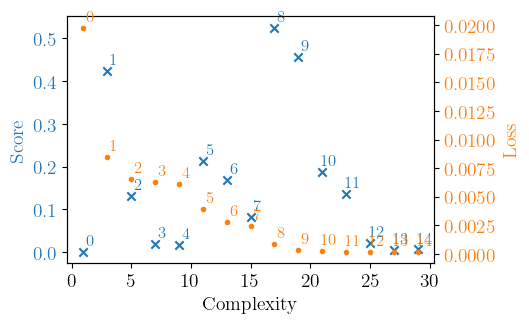

In [33]:
import matplotlib.pyplot as plt

# Obtener los colores de la paleta tab10
colors = plt.get_cmap('tab10').colors

# Crear la figura y el primer eje (izquierdo)
fig, ax1 = plt.subplots()

# Graficar score vs complejidad en el eje izquierdo usando el color tab10[0]
ax1.scatter(complejidades, scores, color=colors[0], marker='x', label='Score')
ax1.set_xlabel('Complexity', fontsize=14)
ax1.set_ylabel('Score', fontsize=14, color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])

# Añadir etiquetas de índice en cada punto para score
for i, (x, y) in enumerate(zip(complejidades, scores)):
    ax1.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color=colors[0])

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# Crear un segundo eje (derecho) que comparte el eje x
ax2 = ax1.twinx()

# Graficar errores vs complejidad en el eje derecho usando el color tab10[1]
ax2.scatter(complejidades, errores, color=colors[1], s=9, marker='o', label='Loss')
ax2.set_ylabel('Loss', fontsize=14, color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])

# Añadir etiquetas de índice en cada punto para errores
for i, (x, y) in enumerate(zip(complejidades, errores)):
    ax2.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color=colors[1])

# Ajustar el gráfico para que no se corten los elementos
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig('../Img/412/Score_Loss_Complexity.png')
plt.savefig('../Img/412/Score_Loss_Complexity.pdf')
plt.savefig('../Img/412/Score_Loss_Complexity.svg')
plt.show()


In [34]:
choose=1
choose_2=4
choose_3=9

exp=model_phi.sympy(choose)*(max_cols_phi-min_cols_phi)+min_cols_phi
exp_2=model_phi.sympy(choose_2)*(max_cols_phi-min_cols_phi)+min_cols_phi
exp_3=model_phi.sympy(choose_3)*(max_cols_phi-min_cols_phi)+min_cols_phi

In [35]:
sympy.expand(exp)


22.449905786607*x1 - 0.574383914470673

In [36]:

sympy.simplify(exp_2)


61.7291374206543*x1*(0.5058921 - 0.3716683*x0**2) - 0.574383914470673

In [37]:
sympy.simplify(exp_3)


(-1.14876782894135*x0**2 + 28.0324329818104*x0*x1 + 0.810625359094936*x0 + 28.6068168962811*x1**2 - 30.6082278653863*x1 - 0.206934850529983)/(2.0*x0**2 + 1.0*x0*x1 - 1.41129537*x0 - 0.33461407*x1 + 0.360272711885891)

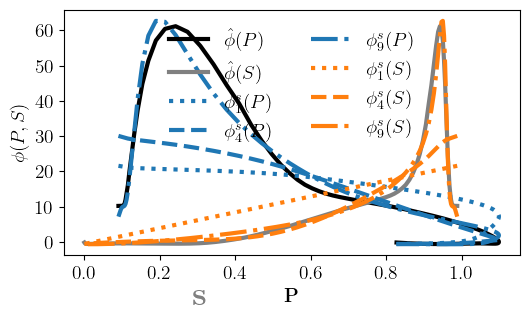

In [38]:
symb1=model_phi.predict(tf.concat([p, s],1),choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb2=model_phi.predict(tf.concat([p, s],1),choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb3=model_phi.predict(tf.concat([p, s],1),choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi

# symb1=model_phi.predict(s,choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb2=model_phi.predict(s,choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb3=model_phi.predict(s,choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi


plt.plot(p, phi_pred,linewidth=3, color='black', label='$\hat{\phi}(P)$')
plt.plot(s, phi_pred,linewidth=3, color='gray', label='$\hat{\phi}(S)$')

# plt.plot(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.plot(p, symb1,linewidth=3, color=colors[0], linestyle=':', label='$\phi^s_1(P)$')
plt.plot(p, symb2,linewidth=3, color=colors[0], linestyle='--', label='$\phi^s_4(P)$')
plt.plot(p, symb3,linewidth=3, color=colors[0],linestyle='-.', label='$\phi^s_9(P)$')
plt.plot(s, symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_1(S)$')
plt.plot(s, symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_4(S)$')
plt.plot(s, symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_9(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


plt.xlabel(r'$\mathbf{P}$', fontsize=14, color='black')
plt.text(0.3, -0.2, r'$\mathbf{s}$', fontsize=24, color='gray', ha='center', transform=plt.gca().transAxes)


# plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/412/Result_phi_s.png')
plt.savefig('../Img/412/Result_phi_s.pdf')
plt.savefig('../Img/412/Result_phi_s.svg')
plt.show()


In [44]:
Nt=10000
P_symb_1=np.zeros(Nt)
P_symb_2=np.zeros(Nt)
P_symb_3=np.zeros(Nt)
S_symb_1=np.zeros(Nt)
S_symb_2=np.zeros(Nt)
S_symb_3=np.zeros(Nt)
T_symb=np.zeros(Nt)
dt=0.0001

P_symb_1[0]=P_symb_2[0]=P_symb_3[0]=np.mean(uu0) #Initial conditions
S_symb_1[0]=S_symb_2[0]=S_symb_3[0]=np.array(tf.exp(u_pred[0,1:2])) #Initial conditions

T_symb[0]=0

for i in range(1,Nt):
    PS=tf.concat([tf.convert_to_tensor(P_symb_1[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb_1[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    P_symb_1[i]=P_symb_1[i-1]+(model_phi.predict(PS,choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi)*P_symb_1[i-1]*dt
    S_symb_1[i]=S_symb_1[i-1]-P_symb_3[i-1]*S_symb_1[i-1]*tf.exp(lnv[0:1])*dt

    PS=tf.concat([tf.convert_to_tensor(P_symb_2[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb_2[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    P_symb_2[i]=P_symb_2[i-1]+(model_phi.predict(PS,choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi)*P_symb_2[i-1]*dt
    S_symb_2[i]=S_symb_2[i-1]-P_symb_2[i-1]*S_symb_2[i-1]*tf.exp(lnv[0:1])*dt

    PS=tf.concat([tf.convert_to_tensor(P_symb_3[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb_3[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    P_symb_3[i]=P_symb_3[i-1]+(model_phi.predict(PS,choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi)*P_symb_3[i-1]*dt
    S_symb_3[i]=S_symb_3[i-1]-P_symb_3[i-1]*S_symb_3[i-1]*tf.exp(lnv[0:1])*dt

    T_symb[i]=T_symb[i-1]+dt

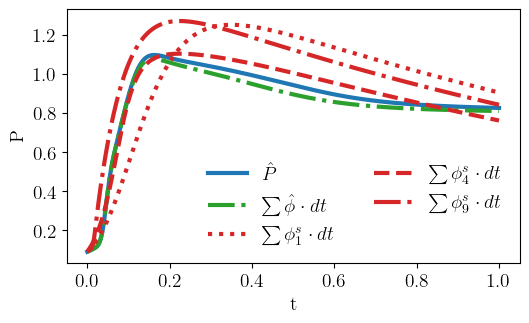

In [45]:
plt.plot(T_star_tf, p, linewidth=3, label='$\hat{P}$')
# plt.plot(T, P, linestyle='--',linewidth=3, label='$P^*$')
plt.plot(T_int, P_int, color=colors[2], linestyle='-.',linewidth=3, label='$\sum \hat{\phi} \cdot dt$')
plt.plot(T_symb, P_symb_1, color=colors[3],linestyle=':',linewidth=3, label='$\sum \phi^s_1 \cdot dt$')
plt.plot(T_symb, P_symb_2, color=colors[3],linestyle='--',linewidth=3, label='$\sum \phi^s_4 \cdot dt$')
plt.plot(T_symb, P_symb_3, color=colors[3],linestyle='-.',linewidth=3, label='$\sum \phi^s_{9} \cdot dt$')



plt.legend(fontsize=14, ncols=2, frameon=False)
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 


plt.tight_layout()
plt.savefig('../Img/412/Result_int_s_p.png')
plt.savefig('../Img/412/Result_int_s_p.pdf')
plt.savefig('../Img/412/Result_int_s_p.svg')
plt.show()

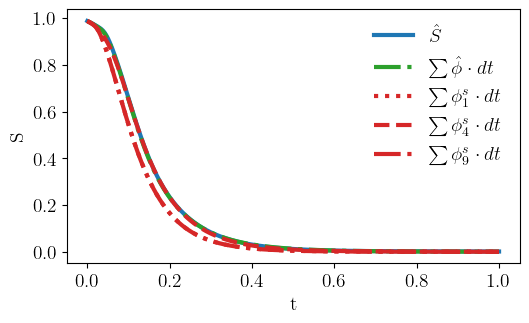

In [46]:
plt.plot(T_star_tf, s, linewidth=3, label='$\hat{S}$')
# plt.plot(T, P, linestyle='--',linewidth=3, label='$P^*$')
plt.plot(T_int, S_int, color=colors[2], linestyle='-.',linewidth=3, label='$\sum \hat{\phi} \cdot dt$')
plt.plot(T_symb, S_symb_1, color=colors[3],linestyle=':',linewidth=3, label='$\sum \phi^s_1 \cdot dt$')
plt.plot(T_symb, S_symb_2, color=colors[3],linestyle='--',linewidth=3, label='$\sum \phi^s_4 \cdot dt$')
plt.plot(T_symb, S_symb_3, color=colors[3],linestyle='-.',linewidth=3, label='$\sum \phi^s_{9} \cdot dt$')



plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 1))
plt.xlabel('t', fontsize=14)
plt.ylabel('S', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 


plt.tight_layout()
plt.savefig('../Img/412/Result_int_s_s.png')
plt.savefig('../Img/412/Result_int_s_s.pdf')
plt.savefig('../Img/412/Result_int_s_s.svg')
plt.show()

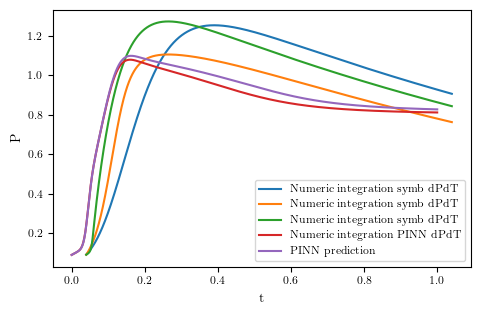

In [42]:
plt.plot(T_symb, P_symb_1, label='Numeric integration symb dPdT')
plt.plot(T_symb, P_symb_2, label='Numeric integration symb dPdT')
plt.plot(T_symb, P_symb_3, label='Numeric integration symb dPdT')


plt.plot(T_int, P_int, label='Numeric integration PINN dPdT')
plt.plot(T_star_tf, p, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

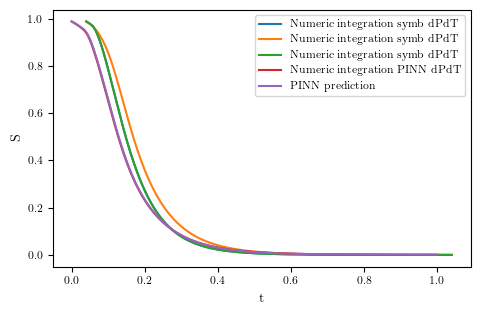

In [43]:
plt.plot(T_symb, S_symb_1, label='Numeric integration symb dPdT')
plt.plot(T_symb, S_symb_2, label='Numeric integration symb dPdT')
plt.plot(T_symb, S_symb_3, label='Numeric integration symb dPdT')

plt.plot(T_int, S_int, label='Numeric integration PINN dPdT')
plt.plot(T_star_tf, s, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('S')
plt.legend()
plt.show()